#### Assigne labels based on intro of the SEED dataset (24s–264s as class 1 and 289s–526s as class 0, others as ignore), and qualitative visualization of class separability in the embedding space.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

npz_path = r"brainbert_outputs\9_1_ch16_first300s_win4s_stride1s_emb.npz"
data = np.load(npz_path, allow_pickle=True)

emb = data["emb"]            # (N, D)
starts = data["starts"]      # (N,)
sfreq = float(data["sfreq"])
win_sec = float(data["win_sec"])
stride_sec = float(data["stride_sec"])

print("Loaded:", npz_path)
print("emb:", emb.shape, "starts:", starts.shape, "sfreq:", sfreq, "win_sec:", win_sec, "stride_sec:", stride_sec)

Loaded: brainbert_outputs\9_1_ch16_first300s_win4s_stride1s_emb.npz
emb: (297, 768) starts: (297,) sfreq: 1000.0 win_sec: 4.0 stride_sec: 1.0


In [5]:
USE_CENTER_TIME = True

times_start_sec = starts / sfreq
if USE_CENTER_TIME:
    times_sec = times_start_sec + 0.5 * win_sec
else:
    times_sec = times_start_sec

In [ ]:
# 24->264: label=1； 289->526: label=0
def label_from_time(t):
    if 24.0 <= t <= 264.0:
        return 1
    if 289.0 <= t <= 526.0:
        return 0
    return -1  # unlabeled / ignore

labels = np.array([label_from_time(t) for t in times_sec], dtype=int)

mask = labels >= 0
emb_l = emb[mask]
labels_l = labels[mask]
times_l = times_sec[mask]

print("Total windows:", len(labels))
print("Labeled windows:", mask.sum())
print("Label counts (0,1):", np.bincount(labels_l))

Total windows: 297
Labeled windows: 251
Label counts (0,1): [ 10 241]


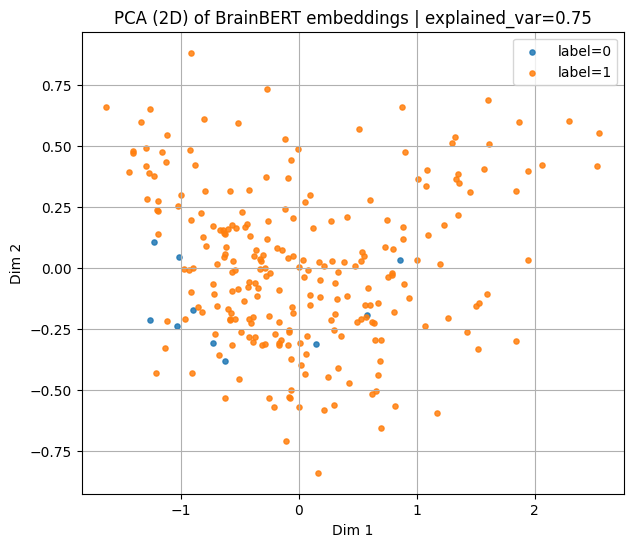

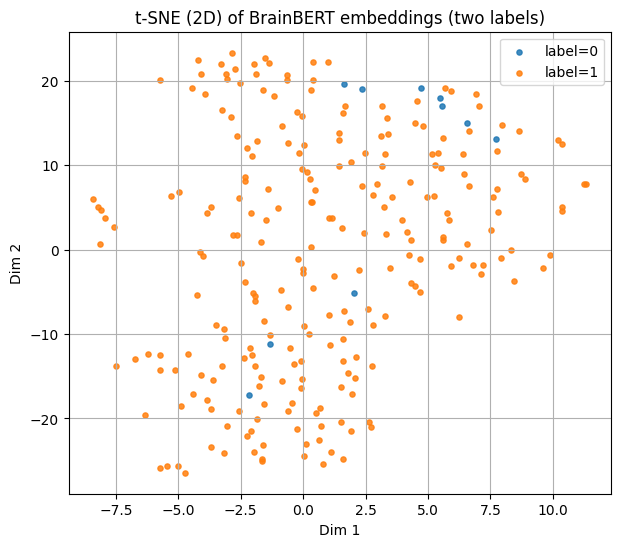

In [ ]:
def plot_2class_scatter(Z, labels, title):
    plt.figure(figsize=(7, 6))
    for cls in [0, 1]:
        m = labels == cls
        plt.scatter(Z[m, 0], Z[m, 1], s=14, label=f"label={cls}", alpha=0.85)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

# PCA
pca = PCA(n_components=2, random_state=0)
Z_pca = pca.fit_transform(emb_l)
plot_2class_scatter(
    Z_pca, labels_l,
    title=f"PCA (2D) of BrainBERT embeddings | explained_var={pca.explained_variance_ratio_.sum():.2f}"
)

# t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=min(30, max(5, (len(emb_l) - 1) // 3)),
    learning_rate="auto",
    init="pca",
    random_state=0
)
Z_tsne = tsne.fit_transform(emb_l)
plot_2class_scatter(Z_tsne, labels_l, title="t-SNE (2D) of BrainBERT embeddings (two labels)")